In [104]:
from typing import Annotated
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults


In [105]:
## Stategraph
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [106]:

import os
from dotenv import load_dotenv
load_dotenv()

True

In [107]:
# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Initialize models
llm = ChatOpenAI(model="gpt-4.1", temperature=0)
embeddings = OpenAIEmbeddings()

In [108]:
## Define the state
class AgentState(MessagesState):
    next_agent: str = ""  # which agent should go next

In [109]:
# Create simple tools
@tool
def search_web(query: str) -> str:
    """Search the web for information."""
    # Using Tavily for web search
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)

@tool
def write_summary(content: str) -> str:
    """Write a summary of the provided content."""
    # Simple summary generation
    summary = f"Summary of findings:\n\n{content[:500]}..."
    return summary

In [110]:
# Define agent functions (simpler approach)
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""
    
    messages = state["messages"]
    
    # Check if system message already exists
    has_system = any(isinstance(msg, SystemMessage) for msg in messages)
    
    # Prepare messages for LLM
    if not has_system:
        system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")
        llm_messages = [system_msg] + messages
    else:
        llm_messages = messages
    
    # Call LLM with tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke(llm_messages)
    
    # Return the response
    return {
        "messages": [response]
    }

In [111]:
def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""
    
    messages = state["messages"]
    
    # Filter out previous system messages and add writer system message
    non_system_messages = [msg for msg in messages if not isinstance(msg, SystemMessage)]
    system_msg = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")
    
    # Simple completion without tools
    response = llm.invoke([system_msg] + non_system_messages)
    
    return {
        "messages": [response]
    }

In [112]:
# Tool executor node
def execute_tools(state: AgentState):
    """Execute any pending tool calls"""
    tool_node = ToolNode([search_web, write_summary])
    return tool_node.invoke(state)

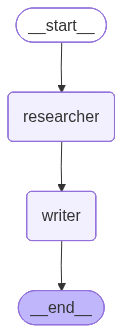

In [113]:
# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)
final_workflow=workflow.compile()

final_workflow

In [114]:
#response = final_workflow.invoke({
#    "messages": [HumanMessage(content="Research about the usecase of agentic ai in business")]
#})


In [115]:
#response["messages"][-1].content

supervise

In [116]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [117]:
# ===================================
# State Definition
# ===================================

# ===================================
# State Definition
# ===================================

class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [118]:
# ===================================
# Supervisor with Groq LLM
# ===================================
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm

In [119]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [120]:
# ===================================
# Agent 1: Researcher (using Groq)
# ===================================

def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [121]:
# ===================================
# Agent 2: Analyst (using Groq)
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [122]:
# ===================================
# Agent 3: Writer (using Groq)
# ===================================

def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [123]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return "__end__"
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

In [124]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            "__end__": END
        }
    )

graph = workflow.compile()
    

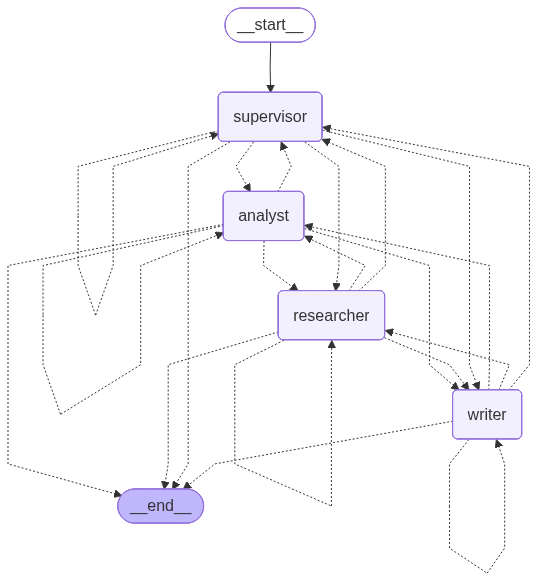

In [125]:
graph

In [126]:
response = graph.invoke({
    "messages": [HumanMessage(content="What are the benefits and risks of AI in healthcare?")]
})


researcher
analyst
writer


In [127]:
# Check if final_report exists in response
if 'final_report' in response and response['final_report']:
    print(response['final_report'])
else:
    print("Final report not yet generated. Current state keys:", list(response.keys()))
    print("\nLast message:", response.get('messages', [])[-1].content if response.get('messages') else "No messages")
    print("\nTask complete:", response.get('task_complete', False))
    print("\nNext agent:", response.get('next_agent', 'unknown'))


📄 FINAL REPORT
Generated: 2025-12-10 12:00
Topic: 📊 Analyst: I've completed the analysis.

Top insights:
Certainly! Here’s a structured data analysis and actionable insights based on your research on the **benefits and risks of AI in healthcare**:

---

## 1. Key Insights and Patterns

- **Rapid Market Growth:** The AI healthcare market is experiencing exponential growth (CAGR ~37%), indicating strong industry momentum and investment.
- **Clinical Performance:** AI systems are achieving diagnostic ac...

---
# Executive Report: Benefits and Risks of AI in Healthcare

## 1. Executive Summary

Artificial Intelligence (AI) is rapidly transforming the healthcare sector, offering significant advancements in diagnostics, operational efficiency, and patient care. The global AI healthcare market is expanding at an estimated CAGR of 37%, driven by technological innovation and increased investment. While AI demonstrates clinical performance on par with human experts and delivers measurable cost